# Praca domowa 2

In [1]:
import pandas as pd
import numpy as np

data = pd.read_stata("hcmst.dta")

In [2]:
data.head(3)

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0


# Wybranie cech:

In [3]:
cat1 = "Q34"             # Ocena jakości związku
cat2 = "ppeduc"          # Najwyzszy zdobyty poziom edukacji
num1 = "Q25"             # Czy chodziliście do tej samej szkoły?
num2 = "Q12"             # Polityczne preferencje partnera
label = "S1"             # Czy jesteście małżeństwem

data = data[[num1,num2,cat1,cat2,label]].dropna()
data.rename(columns={'Q34':'rel_quality','ppeduc':'education','Q25':'same_school','Q12':'partner_politics'}, inplace=True)
data.head()

,same_school,partner_politics,rel_quality,education,S1
1,Different High School,Leans Republican,Excellent,Masters degree,"Yes, I am Married"
2,Different High School,Leans Democrat,Good,Masters degree,"Yes, I am Married"
4,Different High School,Strong Democrat,Excellent,Bachelors degree,"Yes, I am Married"
5,Different High School,Undecided/Independent/Other,Good,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,"Yes, I am Married"
6,Different High School,Leans Republican,Excellent,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,"Yes, I am Married"


In [4]:
data.describe()

,same_school,partner_politics,rel_quality,education,S1
count,2856,2856,2856,2856,2856
unique,3,8,6,14,2
top,Different High School,Undecided/Independent/Other,Excellent,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,"Yes, I am Married"
freq,2406,823,1706,723,2079


In [5]:
from sklearn import preprocessing
    
le = preprocessing.LabelEncoder()

for column_name in data.columns:
    if column_name == "rel_quality":
        data[column_name] = data[column_name].map({
            'Refused':-1, 
            'Excellent':5, 
            "Good":4, 
            "Fair":3, 
            "Poor":2, 
            "Very poor":1
        })
    
    if column_name == "education":
        data[column_name] = data[column_name].map({
            'No formal education':1, 
            '1st, 2nd, 3rd, or 4th grade':2, 
            '5th or 6th grade':3,
            '7th or 8th grade':4,
            '9th grade':5,
            '10th grade':6,        
            '11th grade':7, 
            '12th grade no diploma':8,
            'HIGH SCHOOL GRADUATE - high school DIPLOMA or the equivalent (GED)':9,
            'Some college, no degree':10,
            'Bachelors degree':11,
            'Masters degree':12,
            'Associate degree':13,
            'Professional or Doctorate degree':14, 
        })
    
    if column_name != 'rel_quality' and column_name != 'education' and hasattr(pd.Series(data[column_name], dtype='category'), 'cat'):
        data[column_name] = le.fit_transform(data[column_name].astype(str))
    else:
        pass

# Podział zbioru danych na treningowy i testowy:

In [6]:
from sklearn.model_selection import train_test_split

data = data.dropna()

y = data.loc[:,'S1']
X = data.loc[:, data.columns != 'S1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1863, 4), (919, 4), (1863,), (919,))

# Model:

In [19]:
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=25)

y_pred = random_forest.fit(X_train,y_train).predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.7475516866158868


# Funkcje implementujące wykresy:

In [20]:
import matplotlib.pyplot as plt

def ceteris_paribus_plot(model, num_feature,n1):
    X_temp_1 = X_temp.copy().head(n1)
    
    f_min, f_max = data[num_feature].min(), data[num_feature].max()
    start, stop = (f_min, f_max)
    num_feature_values = np.linspace(start, stop, n1, dtype=int)
    
    X_temp_1[num_feature] = num_feature_values

    y_pred = model.predict_proba(X_temp_1)[:, 1]
    pred_values = pd.DataFrame({'Feature_value':num_feature_values,'Prediction':y_pred})
    
    plt.plot(num_feature_values, y_pred, '#A9A9A9',linewidth=1)
    plt.xlabel(num_feature)
    plt.ylabel("Prawdopodobieństwo małżeństwa")
    
    return pred_values.drop_duplicates().reset_index(drop=True)

In [21]:
def Mplot(num_feature, df):
    feature_values = sorted(list(X_train[num_feature].drop_duplicates()))
    mean_values = []

    for i in range(1,len(feature_values)+1):
        tmp = np.mean(df[df.Feature_value.isin([i-1,i,i+1])])['Prediction']
        mean_values.append(tmp)

    plt.plot(feature_values, mean_values,'r',linewidth=3)
    plt.xlabel(chosen_feature)
    plt.ylabel("Prawdopodobieństwo małżeństwa")

# Wykresy dla wybranych cech:

In [23]:
# Wybranie ilosci probek oraz cechy:
n = 100
chosen_feature = 'education'

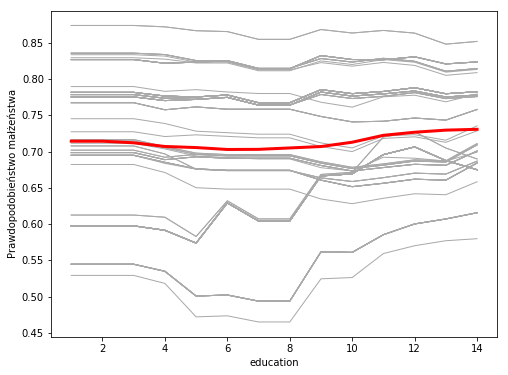

In [24]:
plt.figure(figsize=(8, 6))

sample = X_train.sample(n).reset_index(drop=True)
results = pd.DataFrame(columns=['Feature_value', 'Prediction'])

for i in range(n):
    X_temp = X_train.copy()
    X_temp.loc[:,'same_school'] = int(sample.iloc[i]['same_school'])
    X_temp.loc[:,'partner_politics'] = int(sample.iloc[i]['partner_politics'])
    X_temp.loc[:,'rel_quality'] = int(sample.iloc[i]['rel_quality'])
    X_temp.loc[:,'education'] = int(sample.iloc[i]['education'])

    tmp = ceteris_paribus_plot(random_forest,chosen_feature,500)
    results = results.append(tmp, ignore_index=True)
    
    
Mplot(chosen_feature, results)

In [26]:
# Wybranie ilosci probek oraz cechy:
n = 100
chosen_feature = 'rel_quality'

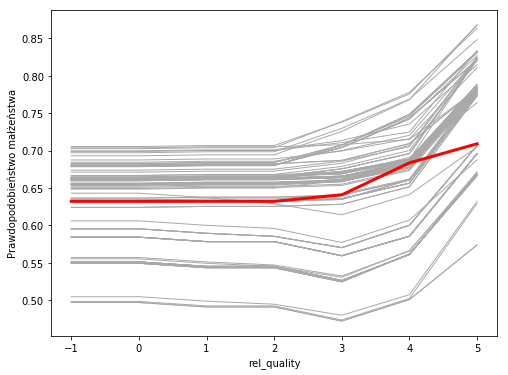

In [27]:
plt.figure(figsize=(8, 6))

sample = X_train.sample(n).reset_index(drop=True)
results = pd.DataFrame(columns=['Feature_value', 'Prediction'])

for i in range(n):
    X_temp = X_train.copy()
    X_temp.loc[:,'same_school'] = int(sample.iloc[i]['same_school'])
    X_temp.loc[:,'partner_politics'] = int(sample.iloc[i]['partner_politics'])
    X_temp.loc[:,'rel_quality'] = int(sample.iloc[i]['rel_quality'])
    X_temp.loc[:,'education'] = int(sample.iloc[i]['education'])

    tmp = ceteris_paribus_plot(random_forest,chosen_feature,500)
    results = results.append(tmp, ignore_index=True)
    
    
Mplot(chosen_feature, results)

# Porównanie z innym modelem:

In [33]:
from sklearn import svm

svm_model = svm.SVC(gamma='scale', probability=True)

y_pred = svm_model.fit(X_train,y_train).predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.7464635473340587


In [39]:
# Wybranie ilosci probek oraz cechy:
n = 100
chosen_feature = 'education'

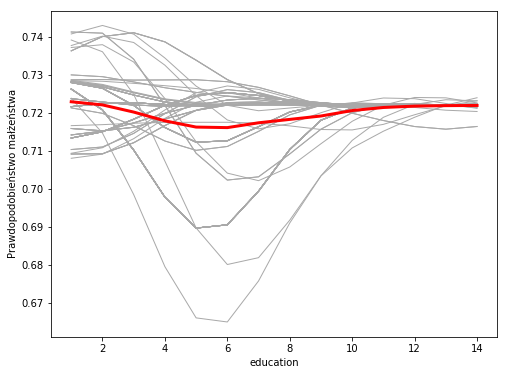

In [32]:
plt.figure(figsize=(8, 6))

sample = X_train.sample(n).reset_index(drop=True)
results = pd.DataFrame(columns=['Feature_value', 'Prediction'])

for i in range(n):
    X_temp = X_train.copy()
    X_temp.loc[:,'same_school'] = int(sample.iloc[i]['same_school'])
    X_temp.loc[:,'partner_politics'] = int(sample.iloc[i]['partner_politics'])
    X_temp.loc[:,'rel_quality'] = int(sample.iloc[i]['rel_quality'])
    X_temp.loc[:,'education'] = int(sample.iloc[i]['education'])

    tmp = ceteris_paribus_plot(svm_model,chosen_feature,500)
    results = results.append(tmp, ignore_index=True)
    
    
Mplot(chosen_feature, results)

In [50]:
# Wybranie ilosci probek oraz cechy:
n = 100
chosen_feature = 'rel_quality'

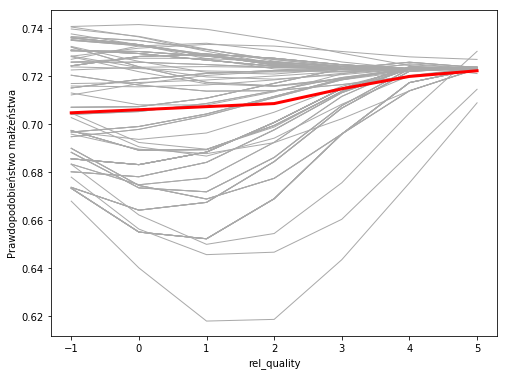

In [51]:
plt.figure(figsize=(8, 6))

sample = X_train.sample(n).reset_index(drop=True)
results = pd.DataFrame(columns=['Feature_value', 'Prediction'])

for i in range(n):
    X_temp = X_train.copy()
    X_temp.loc[:,'same_school'] = int(sample.iloc[i]['same_school'])
    X_temp.loc[:,'partner_politics'] = int(sample.iloc[i]['partner_politics'])
    X_temp.loc[:,'rel_quality'] = int(sample.iloc[i]['rel_quality'])
    X_temp.loc[:,'education'] = int(sample.iloc[i]['education'])

    tmp = ceteris_paribus_plot(svm_model,chosen_feature,500)
    results = results.append(tmp, ignore_index=True)
    
    
Mplot(chosen_feature, results)

# Wnioski:

* Wykresy sugerują, że wybrana zmienna "Edukacja" nie ma dużego wpływu na odpowiedź modelu, ponieważ funkcja Mplot jest prawie prosta.
* Dla zmiennej "Ocena jakości związku" prawdopodobieństwo małżeństwa wzrasta nieznacznie wraz z oceną, jednak nie są to duże zmiany.
* Dwa różne modele, RandomForest oraz SVM, rysują mocno odmienne pojedyncze wykresy Ceteris Paribus, jednak ich uśrednienie wykresem Mplot jest do siebie dość podobne, chociaż nie identyczne.
* Uśrednienie wielu wartości z wykresów Ceteris Paribus pozwala uniknięcia polegania na pojedynczym, losowym wykresie, które jak widać potrafią się między sobą bardzo różnić - nie tylko pomiędzy różnymi modelami, ale również w obrębie jednego modelu